In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import holidays


In [23]:
import random, importlib
import pickle
import xgb_functions as F
from sklearn.metrics import mean_absolute_error, mean_squared_error

data_store_path = "./feature_selection/train_test_data"


In [9]:
# Choose 5 random buses to test feature importances on

chosen_buses = random.sample(range(1, 29), 5)
chosen_buses.sort()
print(chosen_buses)

[1, 2, 12, 15, 18]


In [73]:
# DEFINE HYPERPARAMETERS

# Default hyperparameters
hyperparameters = {"lag_size": 7*24, "n_estimators": 100, "max_depth": 3, "subsample": 1,
                   "selected_features": ["Load", "Hour_cos", "Hour_sin", "Workday"], 
                   "learning_rate": 0.1, "gamma": 0, "lambda": 1,
                   "early_stopping_rounds": None}


# n_estimators determines how many rounds of training (how many new trees can be made)
# early_stopping_rounds determines how many rounds of training can go before validation set score improves from its best score. Needs validation set 
#   to be included when training/fitting. If there is any number, the model with iteration that has best score on validation set will be used when 
#   predicting, even if training is not early stopped. In that case, it will be the same model as changing n_estimators to be the same as best validation iter


In [74]:
# GET ALL TRAINING AND TESTING X AND Y DATA


# Get train-test split for all busses
allbus_df = F.allbus_date_formatting(buses=chosen_buses)

# Get x,y split for all busses
allbus_x, allbus_y = F.get_allbus_xy(allbus_df, hyperparameters, buses=chosen_buses, step_size=1, horizon_size=24) 
# Uses hyperparameters lag_size, selected_features

# Get x,y split for all busses test data
allbus_x_train, allbus_y_train, allbus_x_val, allbus_y_val, allbus_x_test, allbus_y_test = \
    F.allbus_split_train_test(allbus_x, allbus_y, hyperparameters["lag_size"], buses=chosen_buses, train_val_split=1) # No validation

# Store the data in a file
with open(f"{data_store_path}/allbus_train_test.pkl", "wb") as f:
    pickle.dump((allbus_x_train, allbus_y_train, allbus_x_test, allbus_y_test, chosen_buses), f)

In [10]:
# Load back data if needed

with open(f"{data_store_path}/allbus_train_test.pkl", "rb") as f2:
    (allbus_x_train, allbus_y_train, allbus_x_test, allbus_y_test, chosen_buses) = pickle.load(f2)

In [75]:
# TRAIN AND STORE THE MODELS FOR ALL BUSSES

trained_models, model_scores = F.get_models(models_datapath="./feature_selection/MOR_1", hyperparameters=hyperparameters, score_function=mean_absolute_error, 
                                            buses=chosen_buses, allbus_x_train=allbus_x_train, allbus_y_train=allbus_y_train, 
                                            allbus_x_test=allbus_x_test, allbus_y_test=allbus_y_test)

[22:24:44] ======== Monitor (0): HostSketchContainer ========
[22:24:44] AllReduce: 0.008927s, 1 calls @ 8927us

[22:24:44] MakeCuts: 0.011451s, 1 calls @ 11451us

[22:24:44] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 3
[22:24:44] ======== Monitor (0): Learner ========
[22:24:44] Configure: 0.007581s, 1 calls @ 7581us

[22:24:44] EvalOneIter: 0.002032s, 100 calls @ 2032us

[22:24:44] GetGradient: 0.001538s, 100 calls @ 1538us

[22:24:44] PredictRaw: 0.00019s, 100 calls @ 190us

[22:24:44] UpdateOneIter: 0.538851s, 100 calls @ 538851us

[22:24:44] ======== Monitor (0): GBTree ========
[22:24:44] BoostNewTrees: 0.527901s, 100 calls @ 527901us

[22:24:44] CommitModel: 0.000113s, 100 calls @ 113us

[22:24:44] ======== Monitor (0): HistUpdater ========
[22:24:44] BuildHistogram: 0.141127s, 200 calls @ 141127us

[22:24:44] EvaluateSplits: 0.213724s, 300 calls @ 213724us

[

In [81]:
feature_names = [f"L{i}" for i in range(1, hyperparameters["lag_size"] + 1)] + hyperparameters["selected_features"][1:]
print(len(feature_names))

171


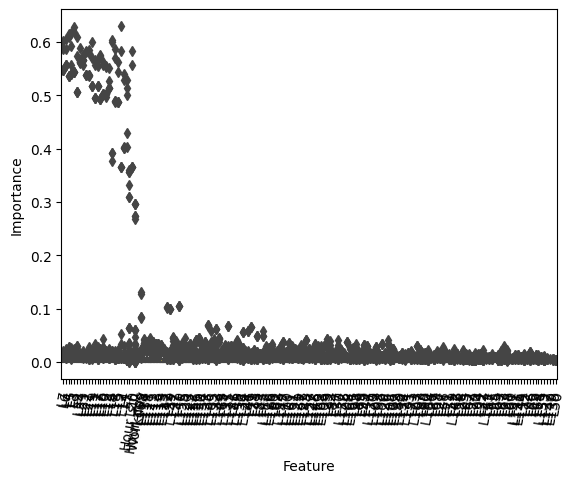

In [82]:
importance_df, sorting, plot = F.get_boxplot(chosen_buses, trained_models, feature_names=feature_names)

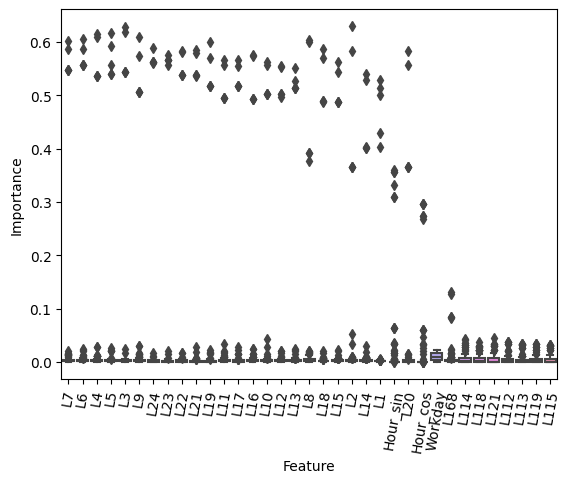

In [107]:
sorting_reduced = sorting.iloc[:35]
importance_df_reduced = importance_df[importance_df["Feature"].isin(sorting_reduced.index)]
plot_reduced = sns.boxplot(data=importance_df_reduced, x="Feature", y="Importance", order=sorting_reduced.index).set_xticklabels(sorting_reduced.index, rotation=80)


C:\Users\bjorn\AppData\Local\Temp\ipykernel_43968\64946572.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_means = sns.scatterplot(data=sorting_reduced, x="Feature", y="Importance").set_xticklabels(sorting_reduced["Feature"], rotation=90)


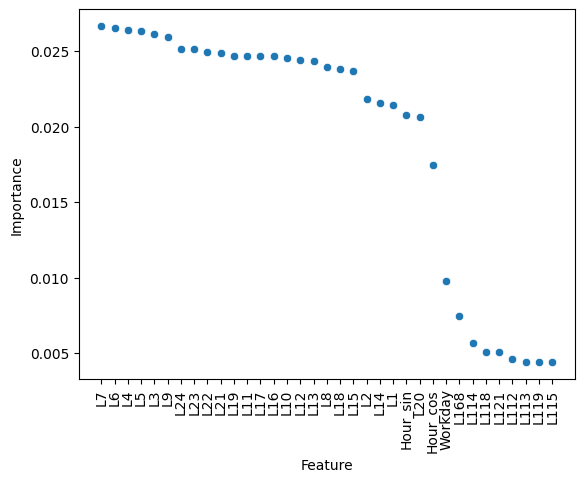

In [108]:
sorting_reduced = sorting_reduced.reset_index(names="Feature")
plot_means = sns.scatterplot(data=sorting_reduced, x="Feature", y="Importance").set_xticklabels(sorting_reduced["Feature"], rotation=90)

In [113]:
with open(f"./feature_selection/important_features.pkl", "wb") as f:
    pickle.dump(sorting_reduced.iloc[0:27], f)